In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from scipy.integrate import odeint

In [2]:
MODEL_PATH = "heat1d.eqx"

In [3]:
def gaussian(size, center, sigma):
    x = np.linspace(-1, 1, size)
    return np.exp(-(x - center) ** 2 / (2 * sigma ** 2))


def random_ic(size, num_gaussians):
    rng = np.random.default_rng()

    y = np.zeros(size)
    for _ in range(num_gaussians):
        y += gaussian(size, rng.uniform(-0.5, 0.5), rng.uniform(0.05, 0.1))

    return y * rng.uniform(1, 10) #Scale


def random_alpha(size):
    rng = np.random.default_rng()

    #Make a random even-order polynomial
    k = rng.integers(1, 4) * 2
    x = np.linspace(-1, 1, size)
    y = np.ones_like(x)
    epsilon = 0.2

    for i in range(1, k):
        if i % 2 == 0:
            y *= x - rng.uniform(-2, -1 - epsilon)
        else:
            y *= x - rng.uniform(1 + epsilon, 2)

    y = np.abs(y)

    return y / np.max(y)

def solve_heat1d(u0, alpha, L, timesteps=100, final_t = 0.1):
    N = u0.size
    dx = L / N
    kappa = 2 * np.pi * np.fft.fftfreq(N, d=dx)
    u0_hat = np.fft.fft(u0)
    u0_hat_ri = np.concatenate((u0_hat.real, u0_hat.imag))

    t = np.linspace(0, final_t, timesteps)

    def rhs(uhat_ri, _, kappa, a):
        uhat = uhat_ri[:N] + 1j * uhat_ri[N:]
        d_uhat = -a**2 * np.power(kappa, 2) * uhat

        return np.concatenate((d_uhat.real, d_uhat.imag))

    full_solution = odeint(rhs, u0_hat_ri, t, args=(kappa, alpha))
    uf_hat_ri = full_solution[-1]
    uf_hat = uf_hat_ri[:N] + 1j * uf_hat_ri[N:]

    return np.real(np.fft.ifft(uf_hat))

In [4]:
def generate_data(nodes=100):
    L = 1
    x = np.linspace(-L/2, L/2, nodes) #(N,)

    y_ic = random_ic(x.size, 3) #(N,)
    a = random_alpha(x.size) #(N,)
    y_f = solve_heat1d(y_ic, a, L) #(N,)

    return y_ic, a, y_f

In [5]:
class SpectralConv1d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            *,
            key
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        #If we have more channels, we must scale down initialized weights to reduce effective VC dimension
        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key, 2)
        self.real_weights = jax.random.uniform(real_key, (in_channels, out_channels, modes), minval=-scale, maxval=scale)
        self.imag_weights = jax.random.uniform(imag_key, (in_channels, out_channels, modes), minval=-scale, maxval=scale)

    def complex_mult1d(self, x_hat, w):
        return jnp.einsum("iM,ioM->oM", x_hat, w)

    def __call__(self, x):
        _, spatial_points = x.shape

        x_hat = jnp.fft.rfft(x) #(in_channels, spatial_points//2 + 1) since a real-valued transform
        x_hat_under_modes = x_hat[:, :self.modes] #(in_channels, self.modes)
        weights = self.real_weights + 1j * self.imag_weights #Complex weights
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights) #(out_channels, self.modes)

        out_hat = jnp.zeros((self.out_channels, x_hat.shape[-1]), dtype=x_hat.dtype) #(out_channels, spatial_points//2+1)
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out

In [6]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(self, in_channels, out_channels, modes, activation, *, key):
        spectral_conv_key, bypass_conv_key = jax.random.split(key, 2)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key
        )
        self.bypass_conv = eqx.nn.Conv1d(in_channels, out_channels, 1, key=bypass_conv_key)
        self.activation = activation

    def __call__(self, x):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )

In [7]:
class FNO1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    fno_blocks: List[FNOBlock1d]
    projection: eqx.nn.Conv1d

    def __init__(self, in_channels, out_channels, modes, width, activation, n_blocks = 4, *, key):
        key, lifting_key = jax.random.split(key, 2)
        self.lifting = eqx.nn.Conv1d(in_channels, width, 1, key=lifting_key)

        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key, 2)
            self.fno_blocks.append(
                FNOBlock1d(
                    width, width, modes, activation, key=subkey
                )
            )

        key, projection_key = jax.random.split(key, 2)
        self.projection = eqx.nn.Conv1d(width, out_channels, 1, key=projection_key)

    def __call__(self, x):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x

In [8]:
fno = FNO1d(
    in_channels=3,
    out_channels=1,
    modes=16,
    width=64,
    activation=jax.nn.silu,
    n_blocks=4,
    key=jax.random.PRNGKey(0)
)

In [9]:
fno = eqx.tree_deserialise_leaves(MODEL_PATH, fno)

In [10]:
#a is the initial condition
#u is the solution at t=1
#Use 1k points to test zero-shot superresolution
y_ic, a, y_f = generate_data(250)

In [11]:
y_ic = y_ic[jnp.newaxis, jnp.newaxis, :]
a = a[jnp.newaxis, jnp.newaxis, :]
y_f = y_f[jnp.newaxis, jnp.newaxis, :]

In [12]:
#Mesh is from 0 to 2pi
mesh = jnp.linspace(0, 2 * jnp.pi, a.shape[-1])

In [13]:
#Add the channels to the input and output
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], a.shape[0], axis=0)
input_with_mesh = jnp.concatenate((mesh_shape_corrected, y_ic, a), axis=1)

In [14]:
in_data = input_with_mesh[0]
ground_truth = y_f[0]

In [15]:
y_hat = fno(in_data)

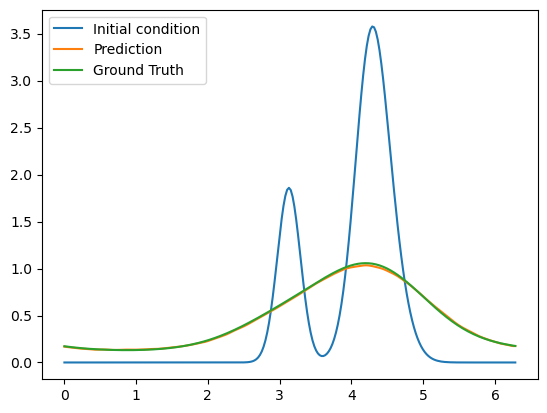

In [16]:
plt.plot(mesh, in_data[1], label="Initial condition")
plt.plot(mesh, y_hat[0], label="Prediction")
plt.plot(mesh, ground_truth[0], label="Ground Truth")
plt.legend()